# check dataset: MQ2008
- MQ2008: https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/letor-4-0/

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import pathlib


import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from dataset import mq2008, prepare_lightgbm_dataset
from eval import calc_ndgc_by_model, calc_ndgc

/Users/yohei/Documents/tutorial/lambdamart/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset: MQ2008

In [3]:
src_path = pathlib.Path("~/Documents/data/MQ2008/Fold1").expanduser()
assert src_path.exists()

dst_path = pathlib.Path("./data/mq2008").resolve()
for dir_path in [*dst_path.parents[::-1], dst_path]:
    if not dir_path.exists():
        dir_path.mkdir()
assert dst_path.exists()

In [4]:
mq2008(src_path, dst_path)

----------------------------------
Characteristics of dataset mq2008 train
rows x columns (9630, 46)
sparsity: 47.22673709874035
y distribution
Counter({0.0: 7820, 1.0: 1223, 2.0: 587})
num samples in queries: minimum, median, maximum
5 8.0 121
----------------------------------
----------------------------------
Characteristics of dataset mq2008 test
rows x columns (2874, 46)
sparsity: 46.112825633112465
y distribution
Counter({0.0: 2319, 1.0: 378, 2.0: 177})
num samples in queries: minimum, median, maximum
6 14.5 119
----------------------------------


## Model: LightGBM LambdaMART

In [5]:
(
    (dtrain, df_train, X_train, y_train, q_train),
    (dval, df_val, X_val, y_val, q_val),
    (dtest, df_test, X_test, y_test, q_test),
) = prepare_lightgbm_dataset(dst_path)

In [6]:
from typing import Optional


def get_params(trial: Optional[optuna.Trial] = None, study: Optional[optuna.Study] = None):
    base_params = {
        # for model
        "boosting_type": "gbdt",
        "objective": "lambdarank",
        "label_gain": "0,1,2",
        # to avoid overfitting
        "learning_rate": 0.1,
        "num_boost_round": 10000,
        "num_leaves": 31,
        "max_depth": -1,
        "min_split_gain": 0.0,
        "min_child_weight": 0.001,
        "min_child_samples": 20,
        "reg_alpha": 0.0,
        "reg_lambda": 0.0,
        # to speed up
        "subsample": 1.0,
        "subsample_freq": 0,
        "colsample_bytree": 1.0,
        # https://robotenique.github.io/posts/gbm-histogram/
        "subsample_for_bin": 200000,
        # for eval
        "metric": "ndcg",
        "eval_at": "10",
        # misc
        "random_state": 1026,
        "n_jobs": -1,
        "saved_feature_importance_type": 0,
        # https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle
        # https://github.com/microsoft/LightGBM/issues/2921
        "use_missing": True,
        "feature_pre_filter": False,
    }

    if trial is not None:
        max_depth = trial.suggest_int("max_depth", 3, 8, step=2)
        num_leaves = trial.suggest_int("num_leaves", 2, int(np.ceil(2**max_depth / 2)), step=2)
        search_params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            "num_leaves": num_leaves,
            "max_depth": max_depth,
            "min_child_samples": trial.suggest_int("min_child_samples", 50, 300, step=10),
            "reg_alpha": trial.suggest_float("reg_alpha", 3e1, 1e2, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e1, 1e2, log=True),
            "subsample": trial.suggest_float("subsample", 0.1, 0.8, step=0.1),
            "subsample_freq": 1,
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.8, step=0.1),
        }
        base_params.update(search_params)
    if study is not None:
        base_params.update(study.best_params)

    return base_params


In [7]:
import numpy.typing as npt
from functools import partial


def objective(
    trial: optuna.Trial,
    dtrain: lgb.Dataset,
    dval: lgb.Dataset,
    X_val: npt.NDArray[np.float64],
    y_val: npt.NDArray[np.float64],
    q_val: npt.NDArray[np.int64],
):
    params = get_params(trial)
    pruning_callback = optuna.integration.LightGBMPruningCallback(
        trial, "ndcg@10", valid_name="val"
    )
    early_stopping_callback = lgb.early_stopping(stopping_rounds=10)
    model = lgb.train(
        params=params,
        train_set=dtrain,
        valid_sets=[dval],
        valid_names=["val"],
        callbacks=[early_stopping_callback, pruning_callback],
        early_stopping_rounds=10,
    )

    ndgc = calc_ndgc_by_model(model, X_val, y_val, q_val)
    return ndgc


In [ ]:
partial_objective = partial(
    objective, dtrain=dtrain, dval=dval, X_val=X_val, y_val=y_val, q_val=q_val
)
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1026),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=10),
)
study.optimize(partial_objective, n_trials=5000, timeout=600)


In [9]:
study.best_params

{'max_depth': 7,
 'num_leaves': 64,
 'learning_rate': 0.08586531948846714,
 'min_child_samples': 90,
 'reg_alpha': 34.65012007320097,
 'reg_lambda': 15.153434905589414,
 'subsample': 0.5,
 'colsample_bytree': 0.2}

In [ ]:
params = get_params(study=study)
early_stopping_callback = lgb.early_stopping(stopping_rounds=10)
log_evaluation_callback = lgb.log_evaluation(period=10)
model = lgb.train(
    params=params,
    train_set=dtrain,
    valid_sets=[dval],
    valid_names=["val"],
    callbacks=[early_stopping_callback, log_evaluation_callback],
    early_stopping_rounds=10,
)

In [11]:
print(calc_ndgc_by_model(model, X_train, y_train, q_train, k=10))
print(calc_ndgc_by_model(model, X_val, y_val, q_val, k=10))
print(calc_ndgc_by_model(model, X_test, y_test, q_test, k=10))

0.5246070308018054
0.529334622764718
0.49378237140114745


In [12]:
# random
score = np.random.rand(len(X_test))
calc_ndgc(score, y_test, q_test, k=10)

0.3313727728892833

In [13]:
# best
score = y_test
calc_ndgc(score, y_test, q_test, k=10)

0.6730769230769231

## Check params

In [14]:
study.best_params

{'max_depth': 7,
 'num_leaves': 64,
 'learning_rate': 0.08586531948846714,
 'min_child_samples': 90,
 'reg_alpha': 34.65012007320097,
 'reg_lambda': 15.153434905589414,
 'subsample': 0.5,
 'colsample_bytree': 0.2}

In [15]:
plot_optimization_history(study)

In [16]:
plot_intermediate_values(study)

In [17]:
plot_param_importances(study)

In [18]:
plot_slice(study, params=["reg_alpha", "num_leaves"])

## Check Feature Importance

In [ ]:
import shap
shap.initjs()

In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


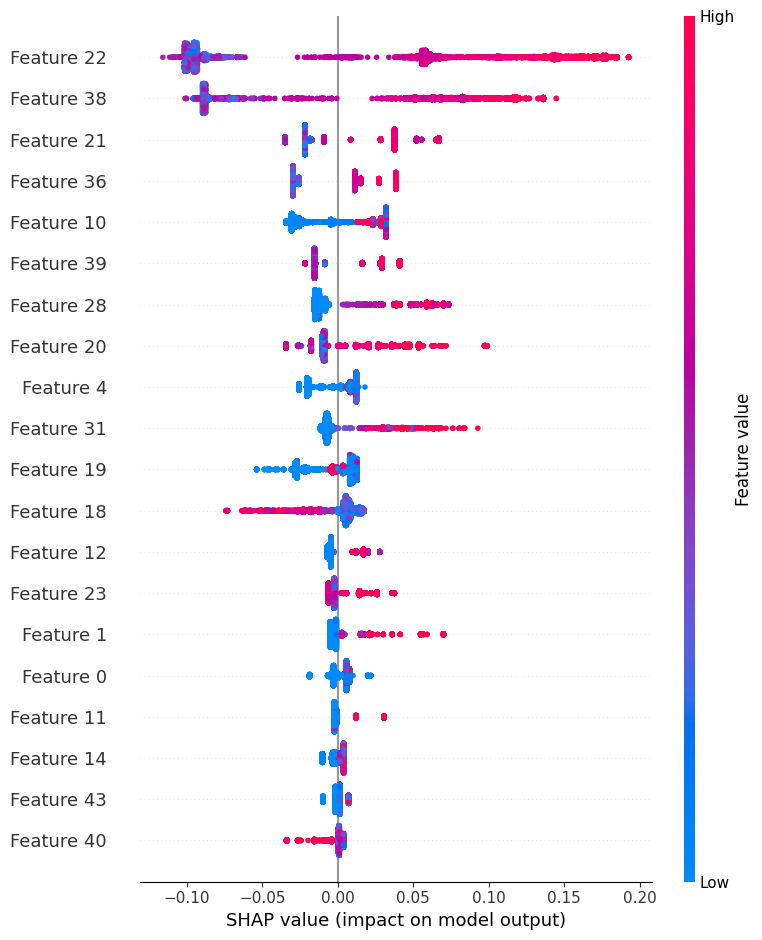

In [21]:
shap.summary_plot(shap_values, X_train)

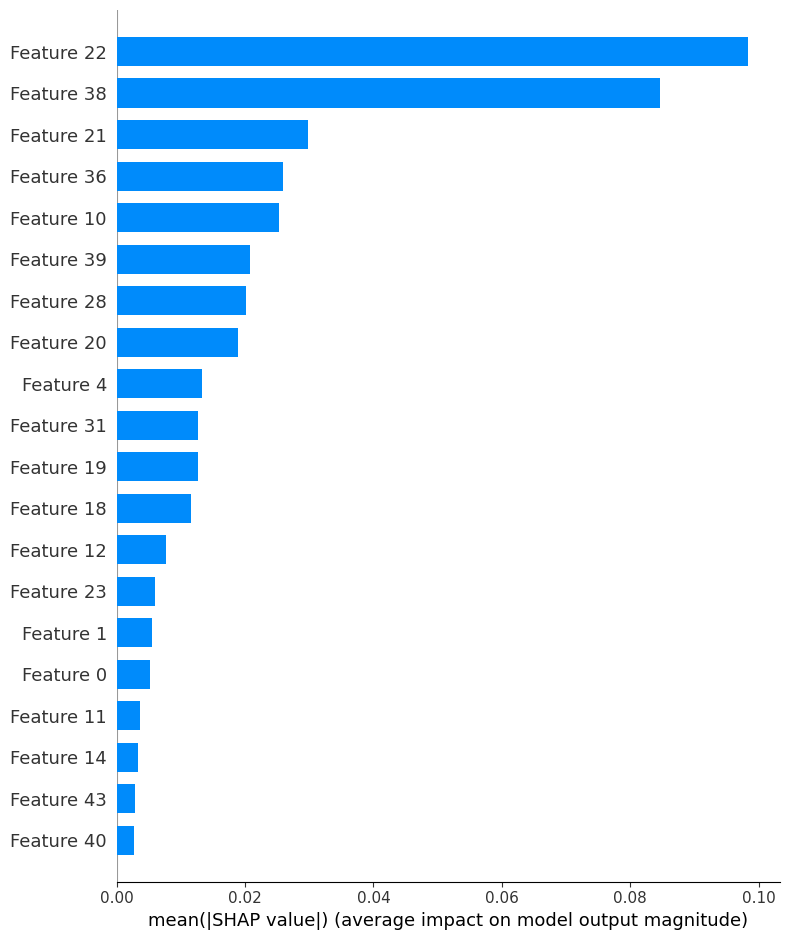

In [22]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

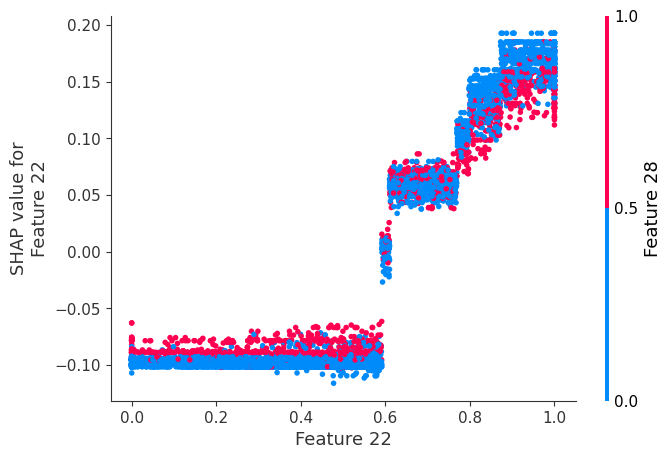

In [25]:
shap.dependence_plot(22, shap_values, X_train)